# Transformerによる時系列予測

# upload modules

In [2]:
src = r'D:\python_code\M5 Competition\transform based forecast\results\src'

In [3]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torch (from versions: none)
ERROR: No matching distribution found for torch


In [25]:
pip install -e .

Obtaining file:///D:/python_code/M5%20Competition/transform%20based%20forecast
Note: you may need to restart the kernel to use updated packages.


ERROR: file:///D:/python_code/M5%20Competition/transform%20based%20forecast does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [10]:
# from distutils.dir_util import copy_tree
from setuptools import setup

setup.copy_tree(src = r"D:\python_code\M5 Competition\transform based forecast\results\src", 
          dst = r"D:\python_code\M5 Competition\transform based forecast\src")


AttributeError: 'function' object has no attribute 'copy_tree'

# import modules

In [ ]:
conda install tqdm

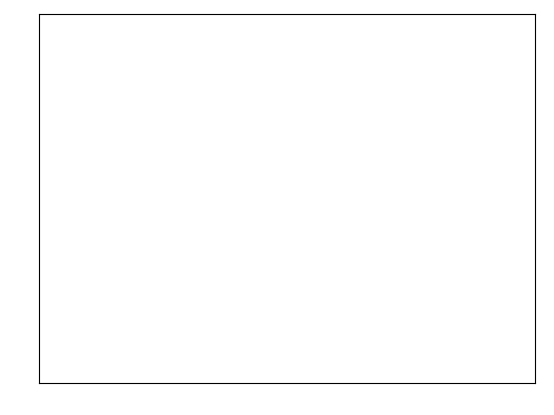

In [1]:
import os
import sys 
import gc 
import warnings 
import random
from pathlib import Path

import numpy as np
import torch 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.getcwd())

seed = 0
random.seed(seed)  
np.random.seed(seed)  
# torch.manual_seed(seed) 

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 5000)

%matplotlib inline
plt.tick_params(colors='white')
sns.set_style("darkgrid")

warnings.simplefilter('ignore', FutureWarning)
# warnings.simplefilter('ignore', pd.core.common.SettingWithCopyWarning)
warnings.simplefilter('ignore', RuntimeWarning)


In [52]:
# src = r'D:\python_code\M5 Competition\transform based forecast\results\src'
from src.data.make_dataset import (
    read_dataset, 
    get_date_cols, 
    merge_dataset
)
from src.features.build_dataset import (
    TSdatasets, 
    setting_dataloader
)

from src.features.build_features import (
    select_activate_items, 
    complement_missing,
    add_base_features,
    feature_enginearing
)
from src.models.eval_model import (
    WRMSSEEvaluator, 
    root_mean_squared_error, 
    eval_quantity
)
from src.models.setting_model import (
    AdaBound, 
    GradualWarmupScheduler
)
from src.models.architecture import TransformerModel
from src.models.loss import RMSELoss
from src.models.setting_model import setting_model
from src.models.train_model import RecursiveModel
from src.visualization.visualize import (
    plot_sales,
    plot_lr_and_sr,
    plot_losses,
    plot_eval, 
    plot_eval_per_group,
    plot_prediction
)
from src.models.predict_model import (
    output_inverse, 
    to_submission
)


# Config

In [4]:
private_sub = False

In [5]:
model_path = 'models/transformer.model'
vis_dir = 'reports/figures'
reports_dir = 'reports'

In [6]:
# dataset
N_IDS = 5000
# N_IDS = 30490
max_train_size = 364 * 5

test_size = 28
d_col = 'd'

# features
diff_trans = False

pow_trans = False
season_diff_interval = 0
# season_diff_interval = 28
std_trans = True
minmax_trans = False

base_cols = [
    'date', 
    'weekday', 
    'month', 
    'year', 
    'event_name_1', 
    'event_type_1', 
    'event_name_2', 
    'event_type_2', 
    'snap_CA', 
    'snap_TX', 
    'snap_WI'
]

num_cols = [
    'sell_price', 
    'is_snap'
]
sales_cat_cols = [
    'id', 
    'item_id', 
    'dept_id', 
    'cat_id', 
    'store_id', 
    'state_id'
]
cat_cols = [
    'quarter', 
    'is_weekend', 
    'part_of_month', 
    'event_name_1', 
    'event_type_1'
]

all_cat_cols = sales_cat_cols + cat_cols 

# if 0, onehot
cat_emb = {
    'id': 80,
    'item_id': 30, 
    'dept_id': 0,
    'cat_id': 0, 
    'store_id': 0, 
    'state_id': 0,
    'quarter': 0,
    'is_weekend': 0,
    'part_of_month': 0,
    'weekday': 3,
    'month': 4,
    'event_name_1': 10,
    'event_type_1':0,
    'event_name_2': 10,
    'event_type_2':0
}



In [7]:
# model
epochs = 30
batch_size = 1024//4
clipping_value = 0.5
log_interval = 1

bptt_x = 28 * 3
bptt_y = test_size
lags = [(1, 6), (7, 28 * 3)] # (tau, period)

all_lags = [lag for tau, period in lags for lag in range(tau, period+1, tau)]
t_emb = sum([lag[1] // lag[0] for lag in lags])
max_tau, max_lag  = lags[-1]

scheduled_sampling = True
src_mask = False
memory_mask = False
nhid = 2048 // 2 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 6 // 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 8 // 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
# fc_dims = [128, 64]
fc_dims = []
activation = 'relu'

lr = 1e-3 # learning rate



# Read

In [8]:
sell_prices, sample_submission, calendar, sales_train = read_dataset(private_sub)

In [9]:
level_cols, train_d_cols, test_d_cols, d2F_map = get_date_cols(
    sales_train, 
    sample_submission, 
    max_train_size, 
    max_lag, 
    private_sub=private_sub
)
    

# Feature engineering

In [66]:
sales_train = sales_train.iloc[:N_IDS, :]

X = merge_dataset(
    sales_train, 
    calendar, 
    sell_prices, 
    base_cols,
    level_cols,
    train_d_cols,
    test_d_cols
)



Running... merge_dataset
0 m 11 s in merge_dataset


In [65]:
del X

In [67]:
X = select_activate_items(X, train_d_cols, test_size, bptt_x, max_lag)

Running... select_activate_items
0 m 11 s in select_activate_items


In [68]:
def complement_missing1(X):
    outlier_event_names = ["Christmas", "Thanksgiving", "NewYear"]
    X["sales_window_12d_mean"] = X.groupby(["id"])["sales"].apply(
        lambda x: x.rolling(window=13, center=True).mean().reset_index(drop=True)
    ).reset_index(drop=True)
    X["sales_window_6w_mean"] = X.groupby(["id", "weekday"])["sales"].apply(
    lambda x: x.rolling(window=7, center=True).mean().reset_index(drop=True)
    ).reset_index(drop=True)
    idx = (X["event_name_1"].isin(outlier_event_names)).values
    X.loc[idx, "sales"] = (
        0.5 * X.loc[idx, "sales_window_12d_mean"]
        + 0.5 * X.loc[idx, "sales_window_6w_mean"]
    )

    X.drop(["sales_window_12d_mean", "sales_window_6w_mean"], axis=1, inplace=True)

    return X

In [69]:
X = complement_missing1(X)
X = add_base_features(X)

Running... add_base_features
0 m 6 s in add_base_features


d:\python_code\M5 Competition\transform based forecast\src\visualization\visualize.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
d:\python_code\M5 Competition\transform based forecast\src\visualization\visualize.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


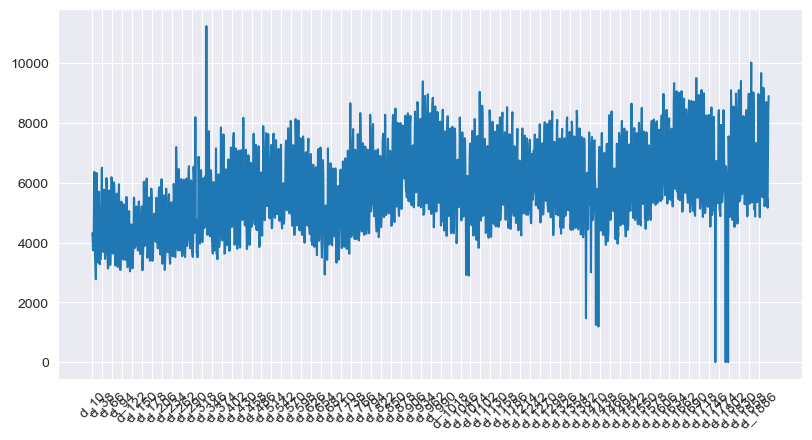

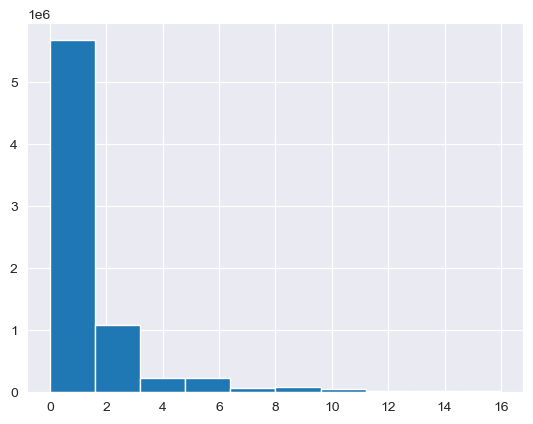

In [70]:
plot_sales(
    X.groupby('d')['sales'].sum(), 
    X['sales'], 
    train_d_cols
)

In [ ]:
X, all_cat_cols, all_num_cols, list_dtrans, id_enc = feature_enginearing(
    X, 
    train_d_cols[max_lag+1:-test_size], 
    test_d_cols, 
    lags, 
    max_lag,
    sales_cat_cols,
    cat_cols,
    num_cols, 
    diff_trans,
    dtrans_map={'sales':[pow_trans, std_trans, minmax_trans, season_diff_interval], 
                'sell_price':[False, True, False, 0]}, 
    clipping_range={'sales': (0.0, 1.0), 
                    'sell_price': (0.0, 1.0)}
)

In [74]:

trainloader, validloader, validmaskloader, testloader = setting_dataloader(
    X, 
    train_d_cols,
    test_d_cols,
    all_num_cols,
    all_cat_cols,
    bptt_x,
    bptt_y,
    max_lag,
    test_size,
    batch_size,
)


Running... setting_dataloader


ValueError: batch_size should be a positive integer value, but got batch_size=0

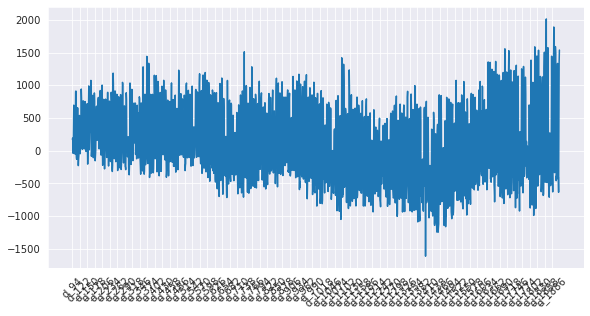

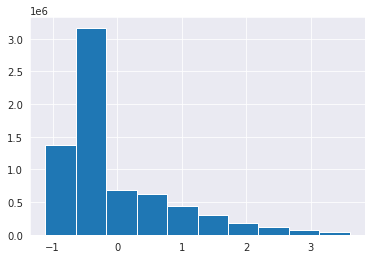

In [14]:
plot_sales(
    X.groupby(['id', 'd'])['sales'].sum().reset_index().pivot(
        index='id', columns='d', values='sales'
    ).sum(0), 
    X['sales'], 
    train_d_cols
)


# Modeling

In [15]:
model_params = dict(
    src_seq_len=bptt_x,
    d_model=len(all_num_cols),
    nhead=nhead,
    nhid=nhid,
    nlayers=nlayers,
    dropout=dropout,
    fc_dims=fc_dims,
    activation=activation,
    use_src_mask=src_mask,
    use_memory_mask=memory_mask,
)

opt_params = dict(lr=lr, weight_decay=1e-4, amsgrad=False)

lr_params = dict(T_max=epochs - (epochs // 10), eta_min=1e-5)

warmup_params = dict(multiplier=1, total_epoch=epochs // 10)

sr_params = dict(
    decay_schedules="inverse_sigmoid_decay",
    k=epochs,
    start=1.0,
    end=0.01,
    slope=0.3,
)


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:484: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


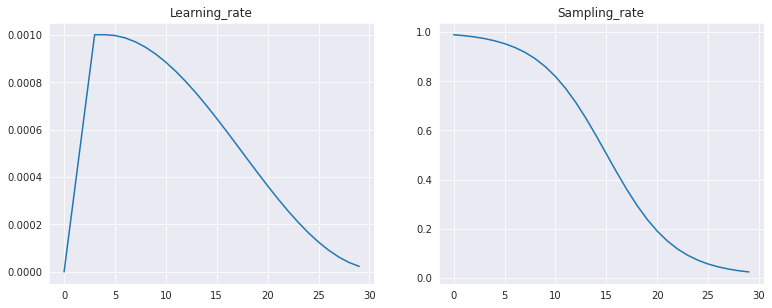

In [16]:
_, optimizer, _, lr_scheduler, sr_scheduler = setting_model(
    X,
    cat_emb,
    all_cat_cols,
    all_num_cols,
    model_params,
    opt_params,
    lr_params,
    warmup_params,
    sr_params,
)

plot_lr_and_sr(epochs, optimizer, lr_scheduler, sr_scheduler)

In [17]:
model = RecursiveModel(bptt_y, all_lags)
model.setting_model(
    *setting_model(
        X,
        cat_emb,
        all_cat_cols,
        all_num_cols,
        model_params,
        opt_params,
        lr_params,
        warmup_params,
        sr_params,
    )
)

In [18]:
model.model

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=168, out_features=168, bias=True)
        )
        (linear1): Linear(in_features=168, out_features=1024, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=1024, out_features=168, bias=True)
        (norm1): LayerNorm((168,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((168,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=168, out_features=168, bias=True)
        )
        (linear1): Linear(in_features=168, out_features=

Training...
Training until validation scores don't improve for 1 rounds
[1] 	 training's RMSELoss: 1.59585 	 valid's RMSELoss: 1.50987 	 | lr=0.00000 	 sr=0.98912
[2] 	 training's RMSELoss: 0.97989 	 valid's RMSELoss: 1.01817 	 | lr=0.00033 	 sr=0.98537
[3] 	 training's RMSELoss: 0.93016 	 valid's RMSELoss: 1.00828 	 | lr=0.00067 	 sr=0.98036
[4] 	 training's RMSELoss: 0.92769 	 valid's RMSELoss: 1.01512 	 | lr=0.00100 	 sr=0.97367
[5] 	 training's RMSELoss: 0.92533 	 valid's RMSELoss: 1.00343 	 | lr=0.00100 	 sr=0.96478
[6] 	 training's RMSELoss: 0.92443 	 valid's RMSELoss: 1.00191 	 | lr=0.00100 	 sr=0.95305
[7] 	 training's RMSELoss: 0.92391 	 valid's RMSELoss: 0.99555 	 | lr=0.00099 	 sr=0.93766
[8] 	 training's RMSELoss: 0.92406 	 valid's RMSELoss: 1.00629 	 | lr=0.00097 	 sr=0.91766
[9] 	 training's RMSELoss: 0.92418 	 valid's RMSELoss: 1.00030 	 | lr=0.00095 	 sr=0.89199
[10] 	 training's RMSELoss: 0.92447 	 valid's RMSELoss: 0.99506 	 | lr=0.00092 	 sr=0.85957
[11] 	 training's

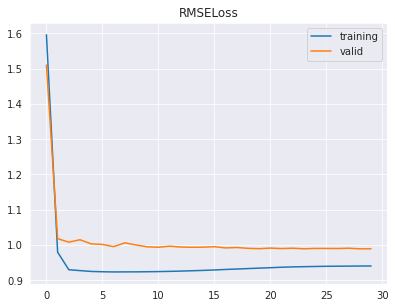

In [19]:
print('Training...')
losses = model.train(model_path, trainloader, validloader, epochs)

del trainloader
gc.collect()

plot_losses(model, losses)

In [20]:
pred_idx = testloader.dataset.en_cat_i[:, 0, 0].argsort()
train_pred_d_cols = train_d_cols[-test_size*2:-test_size]
valid_pred_d_cols = train_d_cols[-test_size:]

trainmaskset = TSdatasets(
    X, 
    train_d_cols[-((test_size * 2) + max_lag):-test_size], 
    all_num_cols, 
    all_cat_cols, 
    bptt_x, 
    bptt_y, 
    max_lag,
    mask=True
)
trainmaskloader = torch.utils.data.DataLoader(
    trainmaskset, batch_size=batch_size, shuffle=False
)

print('Predicting...')

output_train = output_inverse(
    model.predict(trainmaskloader)[pred_idx], 
    list_dtrans[0], 
    id_enc.classes_, 
    train_pred_d_cols,
    diff_trans,
    sales_train.loc[
        :N_IDS, train_d_cols[-test_size*2-1]].values,    
)

output_valid = output_inverse(
    model.predict(validmaskloader)[pred_idx], 
    list_dtrans[0], 
    id_enc.classes_, 
    valid_pred_d_cols,
    diff_trans,
    sales_train.loc[
        :N_IDS, train_d_cols[-test_size-1]].values
)

output_test = output_inverse(
    model.predict(testloader)[pred_idx], 
    list_dtrans[0], 
    id_enc.classes_, 
    test_d_cols,
    diff_trans,
    sales_train.loc[
        :N_IDS, train_d_cols[-1]].values
)


output_train = pd.concat(
    [sales_train[level_cols].set_index('id'), output_train], 
    axis=1
)

output_valid = pd.concat(
    [sales_train[level_cols].set_index('id'), output_valid], 
    axis=1
)

true_train = sales_train[level_cols + train_pred_d_cols[-test_size:]].set_index('id')
true_valid = sales_train[level_cols + valid_pred_d_cols].set_index('id')


  0%|          | 0/20 [00:00<?, ?it/s]

Predicting...


100%|██████████| 20/20 [00:09<00:00,  2.21it/s]


# Evaluation

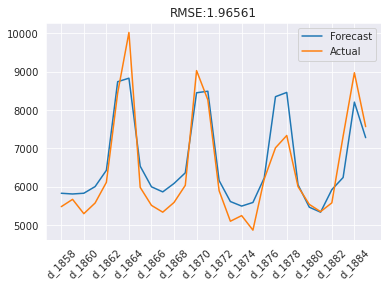

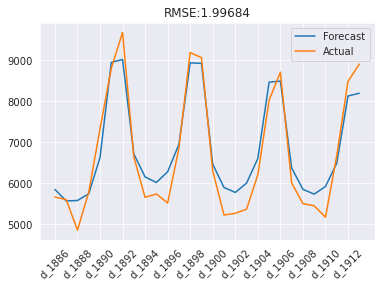

In [21]:
plot_eval(
    Path(vis_dir, 'eval_train'), 
    output_train[train_pred_d_cols[-test_size:]], 
    true_train[train_pred_d_cols[-test_size:]]
)
plot_eval(
    Path(vis_dir, 'eval_valid'), 
    output_valid[valid_pred_d_cols], 
    true_valid[valid_pred_d_cols]
)

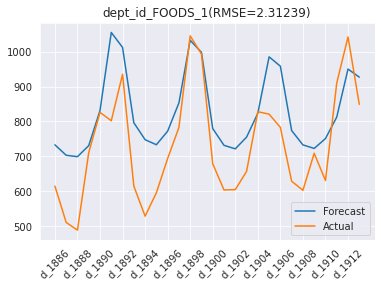

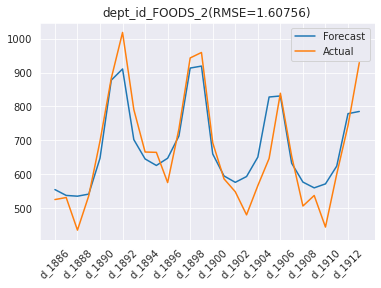

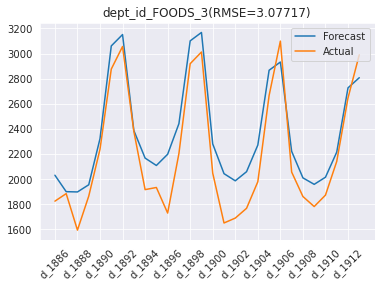

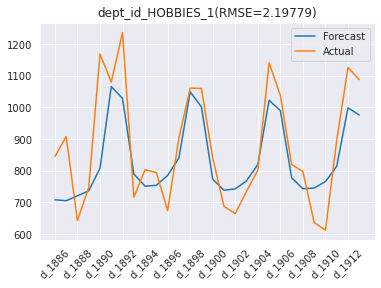

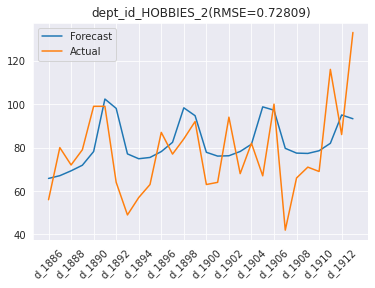

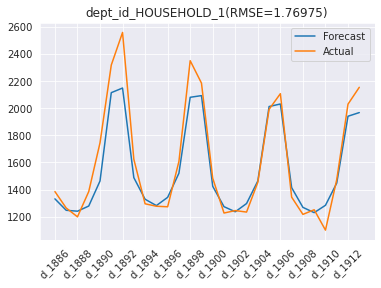

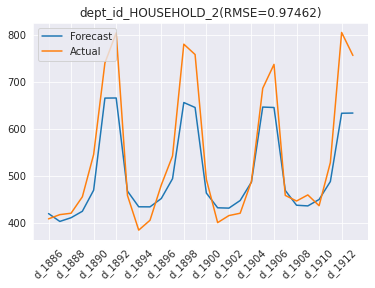

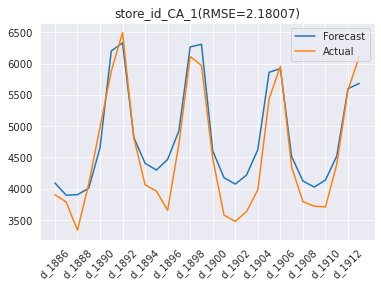

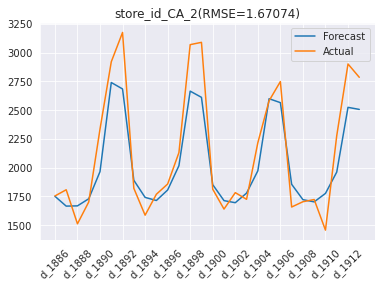

In [22]:
plot_eval_per_group(
    Path(vis_dir, 'eval_valid'), output_valid, true_valid, 'dept_id', valid_pred_d_cols
)
plot_eval_per_group(
    Path(vis_dir, 'eval_valid'), output_valid, true_valid, 'store_id', valid_pred_d_cols
)

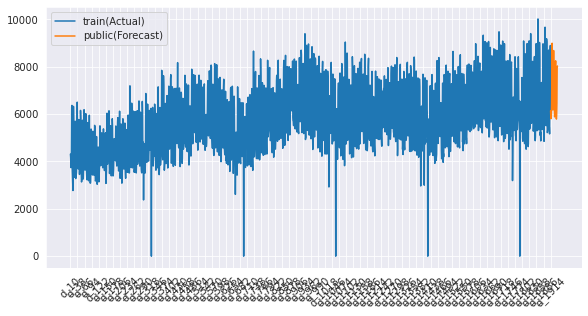

In [23]:
plot_prediction(
    Path(vis_dir, 'pred_test'), 
    sales_train.loc[: N_IDS - 1, train_d_cols], 
    output_test
)

In [24]:
eval_quantity(
    Path(reports_dir, 'eval_results.json'),
    output_valid,
    sales_train,
    calendar,
    sell_prices,
    valid_pred_d_cols,
)


100%|██████████| 11141/11141 [00:01<00:00, 6526.05it/s]


RMSE: 1.996841311454773
WRMSSE_validation: 0.5654035719325108


# Submission

In [ ]:
my_submission = to_submission(
    output_test,
    sales_train,
    sample_submission,
    test_d_cols,
    d2F_map,
    private_sub=private_sub,

)

my_submission.to_csv("submission.csv")eee

In [26]:
my_submission

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,0.690965,0.807736,0.780882,0.802750,0.815418,1.023186,1.051047,0.779334,0.797225,0.788617,0.832523,0.887154,1.118200,0.856417,0.769484,0.761699,0.756538,0.825950,0.848682,1.040767,1.003899,0.769435,0.767476,0.772940,0.826789,0.837613,1.013759,1.009274
HOBBIES_1_002_CA_1_validation,0.242526,0.219331,0.194293,0.210511,0.189003,0.236394,0.276187,0.214811,0.194202,0.193585,0.203924,0.206087,0.268369,0.164430,0.184949,0.180472,0.181504,0.204255,0.193706,0.246176,0.245191,0.192252,0.175355,0.182706,0.201890,0.196719,0.247250,0.243123
HOBBIES_1_003_CA_1_validation,0.476926,0.407650,0.398134,0.464981,0.522683,0.599603,0.675201,0.450168,0.429434,0.445186,0.442997,0.507378,0.635762,0.484297,0.440322,0.433166,0.436287,0.447880,0.493593,0.602164,0.618819,0.455474,0.433859,0.433928,0.448247,0.494655,0.602940,0.593172
HOBBIES_1_004_CA_1_validation,1.758522,1.526313,1.563680,1.734283,1.797304,2.191969,2.828375,1.950517,1.710795,1.666481,1.672767,1.849312,2.479347,2.180297,1.860784,1.650335,1.594819,1.679618,1.861844,2.357730,2.582863,1.903798,1.658466,1.621144,1.691852,1.894302,2.366504,2.516571
HOBBIES_1_005_CA_1_validation,1.160790,1.130128,1.189769,1.196617,1.252826,1.451275,1.723000,1.283917,1.193880,1.169732,1.133360,1.231808,1.547519,1.306631,1.226081,1.155097,1.104231,1.144275,1.202506,1.405194,1.525109,1.161212,1.091396,1.081071,1.116255,1.182836,1.430352,1.481221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FOODS_3_824_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FOODS_3_825_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
